In [9]:
import coniii
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm import tqdm
import pandas as pd
import random

Guide to use coniii solvers: https://github.com/eltrompetero/coniii/blob/py3/ipynb/usage_guide.ipynb

In [2]:
def spinize(traces):
    stds = np.std(traces,axis=-1)
    means = np.mean(traces,axis=-1)
    out = np.zeros_like(traces)
    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            if traces[i,j]-means[i]>stds[i]:
                out[i][j] = 1
            else:
                out[i][j] = -1

    return out



def bootstrap_solve_ACE(X,n_boots=10,sample_size = 0.5,threshold = pow(10,2),n_cpus=8):
    hs = []
    Js = []
    n_units = X.shape[-1]
    for _ in tqdm(range(n_boots)):
        sample_idxs = random.choices(range(len(X)),k=int(X.shape[0]*sample_size))
        X_sample = X[sample_idxs]
        print(X_sample)
        solver = coniii.ClusterExpansion(X_sample,n_cpus = 4)
        multipliers = solver.solve(threshold)
        h,J = multipliers[:n_units],multipliers[n_units:]
        hs.append(h)
        Js.append(J)

    return {'h':hs,'J':Js}
    

In [3]:
traces = np.load('../../../../data/raw_data/nike_calcium_trace.npy')
X = spinize(traces).T
with open('../../../../data/raw_data/behaviour.pickle','rb') as f:
    behaviour = pickle.load(f)
    

In [53]:
?coniii.Pseudo

Init signature:
coniii.Pseudo(
    sample,
    model=None,
    calc_observables=None,
    get_multipliers_r=None,
    calc_observables_r=None,
    k=2,
    iprint=True,
    **default_model_kwargs,
)
Docstring:     
Pseudolikelihood approximation to solving the inverse Ising problem as described in
Aurell and Ekeberg, PRL 108, 090201 (2012).
Init docstring:
For this technique, must specify how to calculate the energy specific to the
conditional probability of spin r given the rest of the spins. These will be
passed in with "get_observables_r" and "calc_observables_r".

Parameters
----------
sample : ndarray or int, None
    If ndarray, of dimensions (samples, dimension). 

    If int, specifies system size.

    If None, many of the default class members cannot be set and then must be set
    manually.
model : class like one from models.py, None
    By default, will be set to solve Ising model.
calc_observables : function, None
    For calculating observables from a set of samples.
get_

# of neurons: 131


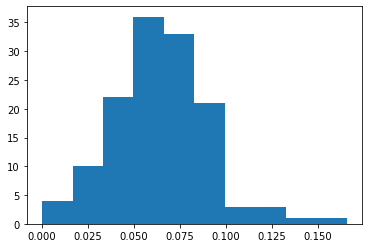

In [4]:
plt.hist(np.sum(X==1,axis=0)/X.shape[0]);

X = X[:, (np.sum(X == 1, axis=0)/X.shape[0]) > 0.01]
print(f"# of neurons: {X.shape[1]}")

In [5]:
# fit a network for each stimulus 
import random

stimulus_duration = 60 # in indexes
stimuli = [1,1]

networks = []

for s in tqdm(stimuli):
    stim_mask = np.zeros(X.shape[0])
    for onset in behaviour[f'sound{s}']:
        stim_mask[onset:onset+stimulus_duration] = 1

    X_stim = X[stim_mask.astype(bool)]
    samples = random.sample(range(len(X_stim)),len(X_stim)//2)
    X_stim = X_stim[samples]
    print(f'# of samples: {len(X_stim)}')
    solver = coniii.Pseudo(X_stim)
    solver.solve()
    networks.append(solver)

        
        
   

  0%|          | 0/2 [00:00<?, ?it/s]/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:125: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")


# of samples: 600


/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:134: UserWarning: Some pairwise correlations have magnitude close to one. Potential for poor solutions from diverging parameters.
  warn(msg)
  0%|          | 0/2 [02:17<?, ?it/s]


KeyboardInterrupt: 

In [13]:
Js = {}
hs = {}
n_neurons = X.shape[-1]
for i,net in enumerate(networks):
    h,J = net.multipliers[:n_neurons],net.multipliers[n_neurons:]
    hs[f'n{i+1}'] = h
    Js[f'n{i+1}'] = J

dfJ = pd.DataFrame.from_dict(Js)
dfh = pd.DataFrame.from_dict(hs)


In [17]:
net = networks[0]

In [27]:
solver = coniii.ClusterExpansion(X_stim[:100,:10],n_cpus=4)


/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:125: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")
/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/samplers.py:1193: UserWarning: Boost C++ implementation not available. Defaulting to slower sampling methods.
  warn("Boost C++ implementation not available. Defaulting to slower sampling methods.")


In [41]:
threshold = 0.1
multipliers,ent,clusters,deltaS,deltaJ = solver.solve(threshold,full_output=True)

adaptiveClusterExpansion: Clusters of size 2


/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


adaptiveClusterExpansion: Clusters of size 3


/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


In [47]:
deltaJ[(4,8,9)]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.28768207,
         0.        ,  0.        ,  0.        ,  0.81989909,  0.25541281],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

In [31]:
data_dict = {'J':dfJ,'h':dfh}
with open('../../../../data/processed_data/network_inference/sound_nets.pikle','wb') as f:
    pickle.dump(data_dict,f)


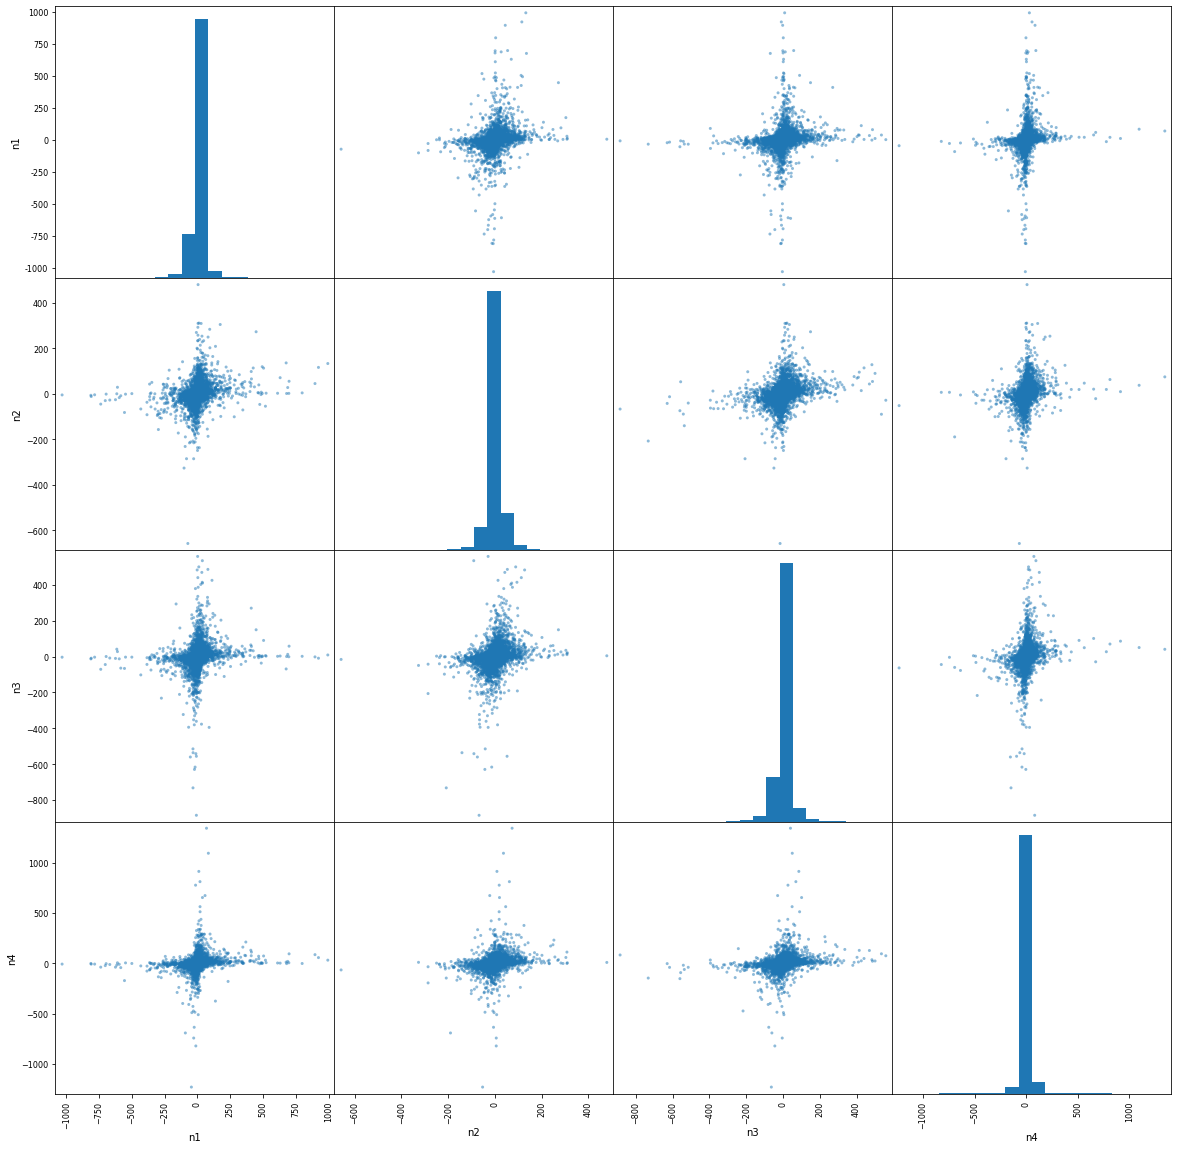

In [15]:
pd.plotting.scatter_matrix(dfJ,figsize=(20,20),hist_kwds={'bins':20},alpha=0.5);


In [16]:
from cProfile import label
from itertools import product
plt.figure(figsize=(5,5))
sns.set_theme(style='white',font_scale=1.5)
for i,n1 in enumerate(dfJ.columns):
    for j,n2 in enumerate(dfJ.columns):
        if i>j:
            sns.scatterplot(data=df,x=n1,y=n2,label=f'{n1}-{n2}')
sns.despine()
plt.xlim([-2000,2000])
plt.ylim([-2000,2000])
plt.legend(loc=(1,0),fontsize=10)


NameError: name 'df' is not defined

<Figure size 360x360 with 0 Axes>

# FIT MODEL ON ALL THE DATA

In [7]:
# fit model on subset of data
n_neurons = sample.shape[1]
n_timepoints = sample.shape[0]
sub_sample = sample[:n_timepoints,:n_neurons]
solver = coniii.Pseudo(sub_sample)
solver.solve()

/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:125: UserWarning: Assuming that calc_observables should be for Ising model.
  if iprint: warn("Assuming that calc_observables should be for Ising model.")
/Users/davide/opt/anaconda3/envs/network_inference/lib/python3.8/site-packages/coniii/solvers.py:134: UserWarning: Some pairwise correlations have magnitude close to one. Potential for poor solutions from diverging parameters.
  warn(msg)


array([ 0.03185614,  0.05206406, -0.01979656, ...,  0.06024016,
        0.0162453 ,  0.00349195])

<AxesSubplot:ylabel='Count'>

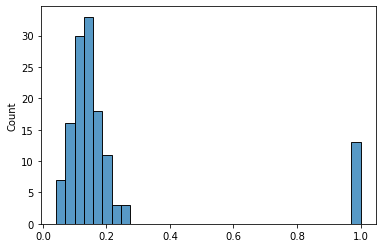

In [9]:
sns.histplot([sum(sample[:,i]==1)/len(sample[:,i]) for i in range(sample.shape[1])])

In [9]:
# unpack fitted value
h,J = solver.multipliers[:n_neurons],solver.multipliers[n_neurons:]

In [13]:
# save data
with open('../../../data/processed_data/pseudo_ll_model.pkl','wb') as f:
    pickle.dump(solver,f)
np.save('../../../data/processed_data/h.npy',h)
np.save('../../../data/processed_data/J.npy',J)

In [14]:
# import data
with open('../../../data/processed_data/pseudo_ll_model.pkl','rb') as f:
    solver = pickle.load(f)

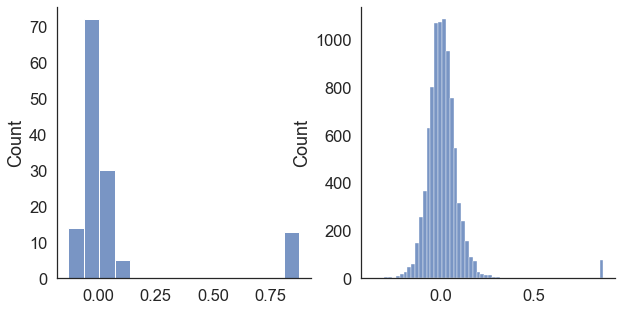

In [16]:
# histograms of values
outlier_th = 1000
n_bins_h = 15
n_bins_J = 60
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5,style='white')
plt.subplot(1,2,1)
sns.histplot(h[np.logical_and(h<outlier_th,h>-outlier_th)],bins=n_bins_h)
sns.despine()
plt.subplot(1,2,2)
sns.histplot(J[np.logical_and(J<outlier_th,J>-outlier_th)],bins=n_bins_J)

sns.despine()

In [17]:
def log_corr(x1,x2):
    a1 = x1==1
    a2 = x2==1
    f1 = sum(a1)/len(a1)
    f2 = sum(a2)/len(a2)
    f12 = sum(a1*a2)/len(a1)
    
    if f1==0 or f2==0:
        out = np.nan
    else:
        out = np.log(f12/(f1*f2))

    return out

In [25]:
CI = []
for i in tqdm(range(n_neurons)):
    for j in range(i+1,n_neurons):
        CI.append(log_corr(sub_sample[:,i],sub_sample[:,j]))

100%|██████████| 134/134 [47:54<00:00, 21.45s/it] 


In [26]:
np.save('../../../data/processed_data/CI.npy',CI)

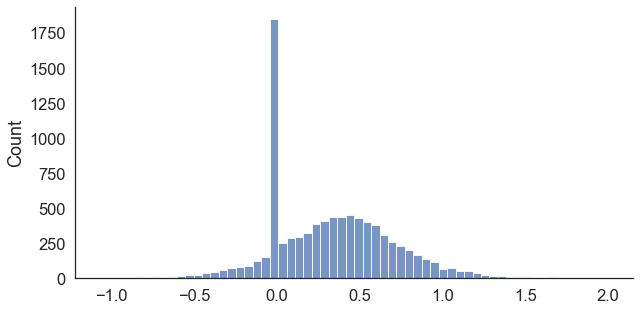

In [27]:
n_bins_CI = 60
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5,style='white')
sns.histplot(CI,bins=n_bins_CI)
sns.despine()

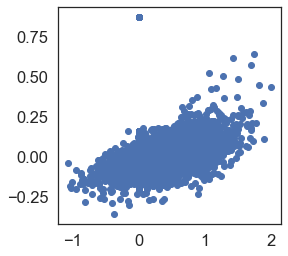

In [32]:
plt.figure(figsize=(4,4))
plt.scatter(CI,J)

# All trial net

In [30]:
import pickle
with open('../../../../data/processed_data/nike/ising_parameters_all_trial.pickle', "rb") as input_file:
    net = pickle.load(input_file)

In [39]:
from scipy.stats import sem

h = np.mean(np.asarray([l[0] for l in net]),axis=0)
delta_h = sem(np.asarray([l[0] for l in net]),axis=0)
t_vals_h = h/delta_h

J = np.mean(np.asarray([l[1] for l in net]),axis=0)
delta_J = sem(np.asarray([l[1] for l in net]),axis=0)
t_vals_J = J/delta_J


<AxesSubplot:ylabel='Count'>

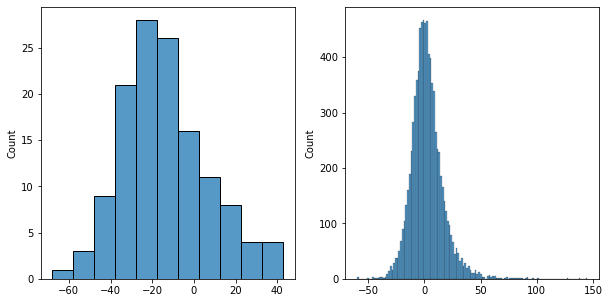

In [49]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(t_vals_h)

plt.subplot(1,2,2)
sns.histplot(t_vals_J)

<AxesSubplot:ylabel='Count'>

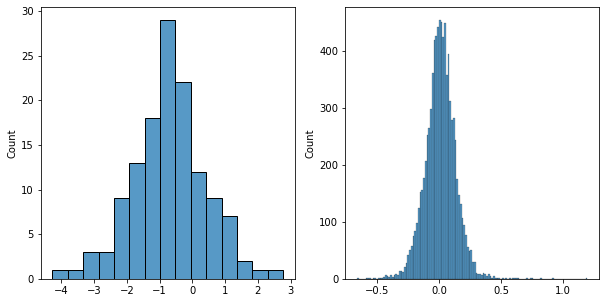

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(h)

plt.subplot(1,2,2)
sns.histplot(J)

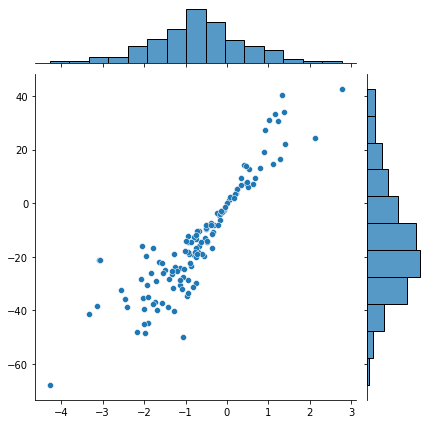

In [51]:
sns.jointplot(x=h,y=t_vals_h)

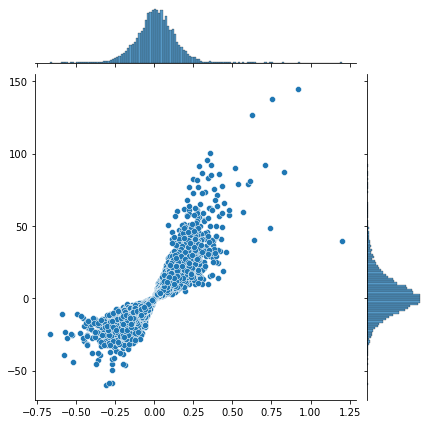

In [52]:
sns.jointplot(x=J,y=t_vals_J)